In [1]:
import tensorflow as tf
import numpy as np
import networkx as nx
import math
from scipy.sparse.linalg import eigsh
import time
import networkx.algorithms.community as algos
from sklearn.cluster import KMeans

In [13]:
def import_graph(file_name):
    # this code block just imports the dataset as a networkx network
    import re
    lineFinder = re.compile('(\d+\s+\d+.*\n)')

    with open(file_name, 'r') as f:
        file = f.read()
    singleLines = list(map(lambda x: np.fromstring(x, dtype=int, sep=' '), lineFinder.findall(file)))
    G = nx.from_edgelist(np.column_stack(singleLines).T)
    G = nx.convert_node_labels_to_integers(G)
    #print(G.size())
    giant = max(nx.connected_components(G), key=len)
    G = G.subgraph(giant).copy()
    mapping = dict(zip(G.nodes(),[n for n in range(len(G.nodes))]))
    G = nx.relabel_nodes(G,mapping)
    #print(nx.number_connected_components(G))
    #print(len(G.nodes()))
    return G
    
def generate_laplacian(G):
    # This chunk of code builds the graph laplacian
    from scipy.sparse import lil_matrix
    adjacency_matrix = lil_matrix((len(G.nodes()), len(G.nodes())))
    #diag_matrix = lil_matrix((len(G.nodes()), len(G.nodes())))
    normal_laplacian = lil_matrix((len(G.nodes()), len(G.nodes())))
    #print(adjacency_matrix.shape)
    G = nx.convert_node_labels_to_integers(G)
    # initialize diagonal so we can compute laplacian in one go
    for edge in G.edges():
        adjacency_matrix[edge[0],edge[0]] = 0
        adjacency_matrix[edge[1],edge[1]] = 0
    for edge in G.edges():
        adjacency_matrix[edge[0],edge[1]] = -1
        adjacency_matrix[edge[1],edge[0]] = -1
        adjacency_matrix[edge[0],edge[0]] += 1
        adjacency_matrix[edge[1],edge[1]] += 1
    #print(adjacency_matrix.getnnz())
    # normalizes laplacian, not a necessary step, but I find it helps
    for edge in G.edges():
        degree_v1 = adjacency_matrix[edge[0],edge[0]]
        degree_v2 = adjacency_matrix[edge[1],edge[1]]
        total_deg1 = -1/(math.sqrt(degree_v1*degree_v2))
        normal_laplacian[edge[0],edge[1]] = total_deg1
        normal_laplacian[edge[1],edge[0]] = total_deg1
        normal_laplacian[edge[0],edge[0]] = 1.0
        normal_laplacian[edge[1],edge[1]] = 1.0
    #print(normal_laplacian.getnnz())
    return normal_laplacian

def generate_vectors(normal_laplacian,num_eigenvals,relaxation = 5):
    # solve for eigenvectors, smallest first ("SA" stands for smallest arithmetic)
    #start_time = time.time()
    eigenvalues, eigenvectors = eigsh(normal_laplacian, k=num_eigenvals, which='SA')
    #print("eigenvectors found in ",time.time()-start_time)
    unrelaxed_eigenvectors =[]
    for i in range(len(eigenvectors)):
        new_vec = []
        for j in range(len(eigenvectors[0])):
            if eigenvectors[i][j] > 0:
                #new_vec.append(1)
                new_vec.append(eigenvectors[i][j]**(1/relaxation))
            else:
                #new_vec.append(-1)
                new_vec.append(-(-eigenvectors[i][j])**(1/relaxation))
        unrelaxed_eigenvectors.append(new_vec)
    return unrelaxed_eigenvectors

def mod_score(clusters,Graph):
    total_sum = 0
    m = len(Graph.edges())
    for cluster in clusters:
        summation = len(Graph.subgraph(cluster).edges())
        totaldegree=sum(n for _, n in Graph.degree(cluster)) 
        total_sum += ((summation/m)-(totaldegree/(2*m))**2)
    return total_sum

def sig_kmeans_test(k,vecs):
    kmeans = KMeans(n_clusters=k,precompute_distances=True).fit_predict(vecs)
    result = []
    for j in range(k):
        result2 = set()
        for i in range(len(kmeans)):
            if(kmeans[i]==j):
                result2.add(i)
        result.append(result2)
    return result

In [3]:
# Options CA-GrQc.txt p2p-Gnutella04.txt facebook_combined.txt (in ascending order with size)
G = import_graph('facebook_combined.txt')
L = generate_laplacian(G)

In [15]:
vec_key = []
com_key = []
modularity = []
times = []
for num_vecs in range(1,5):
    start_constant = time.time()
    vectors = generate_vectors(L,num_vecs,3)
    cost = time.time()-start_constant
    for num_communities in range(1,5):
        start_variable = time.time()
        communities = sig_kmeans_test(num_communities,vectors)
        timer = cost+time.time()-start_variable
        print(num_vecs, ",", num_communities, ",", mod_score(communities,G),",",timer)
        vec_key.append(num_vecs)
        com_key.append(num_communities)
        modularity.append(mod_score(communities,G))
        times.append(timer)
    for num_communities in range(5,51,5):
        start_variable = time.time()
        communities = sig_kmeans_test(num_communities,vectors)
        timer = cost+time.time()-start_variable
        print(num_vecs, ",", num_communities, ",", mod_score(communities,G),",",timer)
        vec_key.append(num_vecs)
        com_key.append(num_communities)
        modularity.append(mod_score(communities,G))
        times.append(timer)
        
for num_vecs in range(5,101,5):
    start_constant = time.time()
    vectors = generate_vectors(L,num_vecs,3)
    cost = time.time()-start_constant
    for num_communities in range(1,5):
        start_variable = time.time()
        communities = sig_kmeans_test(num_communities,vectors)
        timer = cost+time.time()-start_variable
        print(num_vecs, ",", num_communities, ",", mod_score(communities,G),",",timer)
        vec_key.append(num_vecs)
        com_key.append(num_communities)
        modularity.append(mod_score(communities,G))
        times.append(timer)
    for num_communities in range(5,51,5):
        start_variable = time.time()
        communities = sig_kmeans_test(num_communities,vectors)
        timer = cost+time.time()-start_variable
        print(num_vecs, ",", num_communities, ",", mod_score(communities,G),",",timer)
        vec_key.append(num_vecs)
        com_key.append(num_communities)
        modularity.append(mod_score(communities,G))
        times.append(timer)
        

5 , 1 , 0.0 , 31.83291721343994
5 , 2 , 0.4709501065942646 , 31.84806489944458
5 , 3 , 0.6533830362080677 , 31.860448122024536
5 , 4 , 0.6669416510185189 , 31.866353273391724
5 , 5 , 0.6841207129833078 , 31.875660181045532
5 , 10 , 0.6449680649973891 , 31.96752405166626
5 , 15 , 0.5992044231019599 , 32.03780698776245
5 , 20 , 0.5494088307444068 , 32.12343192100525
5 , 25 , 0.4842610665080031 , 32.207051038742065
5 , 30 , 0.4571138293295523 , 32.25336813926697
5 , 35 , 0.4425895989181402 , 32.32668733596802
5 , 40 , 0.4167889424713233 , 32.3722460269928
5 , 45 , 0.3880154573515046 , 32.41743516921997
5 , 50 , 0.3487238296844341 , 32.51850509643555
10 , 1 , 0.0 , 12.820794820785522
10 , 2 , 0.4839909173750201 , 12.840165853500366
10 , 3 , 0.6470349728989095 , 12.847389936447144
10 , 4 , 0.664882208976662 , 12.859348058700562
10 , 5 , 0.7062810776692383 , 12.869892835617065
10 , 10 , 0.820993930670917 , 12.92641806602478
10 , 15 , 0.8071214205418261 , 13.012195825576782
10 , 20 , 0.768844

KeyboardInterrupt: 

Text(0.5, 0, 'Time')

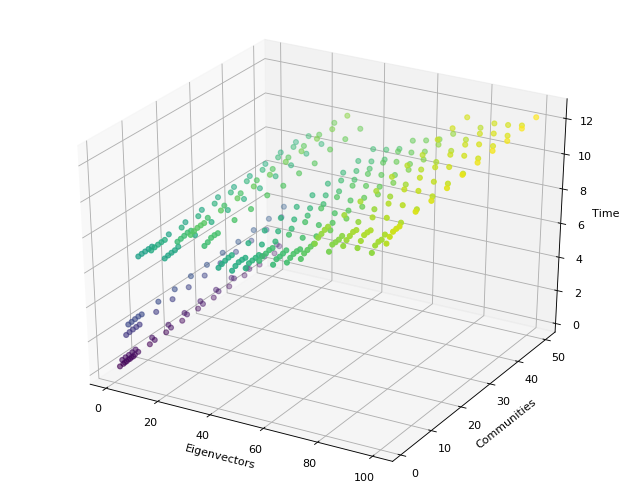

In [20]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd
#options 3dPhysics.csv 3dGnutella.csv 3dFacebook.csv
df = pd.read_csv('3dPhysics.csv')

vec_key = df['eigenvectors']
com_key = df['communities']
modularity = df['modularity']
times = df['time']
fig = plt.figure(num=None, figsize=(10, 8), dpi=80)
ax = plt.axes(projection='3d')
#ax.scatter(vec_key, com_key, modularity,c=modularity,cmap='viridis')
ax.scatter(vec_key, com_key, times,c=times,cmap='viridis')
ax.set_xlabel('Eigenvectors')
ax.set_ylabel('Communities')
#ax.set_zlabel('Modularity')
ax.set_zlabel('Time')


In [ ]:
import numpy as np
from numpy import linalg as LA
import time

def connected_component_subgraphs(G):
    subgraphs = []
    for c in nx.connected_components(G):
        subgraphs.append(G.subgraph(c))
    return subgraphs


def specClust(k,G):
    start_time = time.time()
    numGraphs = 1 #Start with 1 graph
    graphlets = [G] #Create an array to store graphlets
    while len(graphlets) < k: #Keep dividing until we hit k graphlets
        if nx.number_of_nodes(graphlets[0]) > 1:
            subgraphs = divideGraph(graphlets[0]) 
            graphlets.remove(graphlets[0])
            for x in range(0,len(subgraphs)): #Add in new graphlets we create
                graphlets.append(subgraphs[x])
        else:
            graphlets.append(subgraphs[0])
            graphlets.remove(graphlets[0])
        modularity = mod_score(graphlets, G)
        print(str(len(graphlets)) + " , " + str(time.time() - start_time) + " ; ") #Report Runtime
                

def divideGraph(G):
#     L = generate_laplacian(G)
#     vectors = generate_vectors(L,2,1)
#     array = np.array(vectors)
#     transpose = np.transpose(array)
#     fiedler = transpose[1]
    try: #Compute Fiedler Vector. 
        fiedler = nx.fiedler_vector(G, weight=None, normalized=False, tol=1e-08, method='tracemin_pcg', seed=None)
    except:
        return connected_component_subgraphs(G)
    #Partition Graph (same logica as the above, just partition at 0 rather than at median.)
    posNodes = []
    negNodes = []
    i = 0
    for node in G.nodes(): #Sort Nodes.
        if fiedler[i] < 0:
            negNodes.append(node)
        else:
            posNodes.append(node)
        i = i+1
    posGraph = G.subgraph(posNodes) #Create Two Subgraphs.
    negGraph = G.subgraph(negNodes)
    return [posGraph, negGraph] #Return result.

print(nx.number_connected_components(G))
specClust(101,G)

1
2 , 10.577085256576538 ; 
3 , 10.859529972076416 ; 
3 , 32.87375807762146 ; 
4 , 32.92553210258484 ; 
5 , 33.57986497879028 ; 
6 , 81.44664692878723 ; 
7 , 81.50678014755249 ; 
8 , 81.56074810028076 ; 
9 , 81.63469099998474 ; 
10 , 82.21587920188904 ; 
11 , 82.56079411506653 ; 
12 , 87.98015213012695 ; 
13 , 88.0193190574646 ; 
14 , 88.06425595283508 ; 
15 , 88.10008502006531 ; 
16 , 88.13459801673889 ; 
17 , 88.17555093765259 ; 
18 , 88.27877306938171 ; 
19 , 88.32805013656616 ; 
20 , 88.52414608001709 ; 
21 , 88.63016319274902 ; 
22 , 88.76580023765564 ; 
23 , 88.86125302314758 ; 
24 , 118.79497909545898 ; 
25 , 118.83324098587036 ; 
26 , 118.87186002731323 ; 
27 , 118.90940690040588 ; 
28 , 118.9552628993988 ; 
28 , 118.9916729927063 ; 
29 , 119.02921485900879 ; 
30 , 119.06721210479736 ; 
30 , 119.1041169166565 ; 
31 , 119.14902400970459 ; 
32 , 119.21236300468445 ; 
33 , 119.26068496704102 ; 
34 , 119.31328296661377 ; 
35 , 119.35784387588501 ; 
36 , 119.43236923217773 ; 
37 , 1